# Lab 3: Introduction to Unsupervised Learning

### Overview
This lab will provide a brief introduction to *unsupervised* learning through, using two algorithms: *K-means* and *Expectation-Maximization* (EM). Unlike the previous lab, where we looked at supervised learning, unsupervised learning algorithms work on data that does not have a ground truth label to supervise over. Hence the goal of these algorithms is to find hidden patterns in unlabeled data, where in this lab we look specifically at clustering. 

#### I. Data Processing - Spotify Dataset
#### II. K-means Clustering 
#### III. Binary Gaussian Mixtures 
#### IV. EM Algorithm

### Assignment 
You are required to provide the code for *two* questions throughout the notebook, which correspond to the two algorithms:
- **Question 1**: Implementing K-Means
- **Question 2**: Implementing EM




In [1]:
import numpy as np 
import pickle
import os
from numpy.random import default_rng
from scipy.stats import norm
import pandas as pd

rng = default_rng(seed=12345)

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
# colors used 
ORANGE = '#FF9132'
TEAL = '#0598B0'
GREEN = '#008F00'
PURPLE = '#8A2BE2'
GRAY = '#969696'
RED = '#B00805'
FIG_WIDTH = 4
FIG_HEIGHT = 3


plt.rcParams.update({
    "text.usetex": False,
    "font.size": 12,
    "axes.titlesize": 15,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "lines.linewidth": 3
})


#### I. Data Processing - Spotify Dataset

We have all seen K-Means in class, and it looks pretty simple right? Can it really work on real datasets where the features express complex quantities? Yes, but remember, K-Means is not created to be a classification algorithm, but rather a clustering algorithm. That is why it is usually used in recommendation systems, and not prediction systems. 

For our task, we will use a small subset of data from spotify, choosing **3 artists**, and collecting **200 songs from each**. The dataset that we want to cluster consists of these **600** shuffled songs, with each song having **11 features**. We will try to use these features, and the K-Means algorithm to seperate the 600 songs into **3 clusters**. 

Since the true labels are provided, we can then check how the unsupervised learning framework did i.e., do the created clusters represent the artists?

While I will provide you with some simple data processing code that I use for visualization, it will be up to you to decide how to use it for implementing K-Means.

In [2]:
cwd = os.getcwd()
# display your current working directory
print(cwd)
# read in the mnist dataset
spotify_path = cwd + '/data/spotify.csv'
df = pd.read_csv(spotify_path)
print(df["artist"].value_counts())
df.head()

/home/mark/Documents/code/ml_tutorial/content/lab3
artist
Drake          200
The Beatles    200
BTS            200
Name: count, dtype: int64


,artist,popularity,duration_ms,danceability,energy,key,loudness,speechiness,acousticness,liveness,valnce,tempo
0,Drake,60.0,106333.0,0.699,0.255,4.0,-8.647,0.0303,0.40500,0.0985,0.2420,132.031
1,The Beatles,55.0,154160.0,0.552,0.644,9.0,-9.129,0.0372,0.67500,0.3600,0.9610,122.546
2,Drake,66.0,262453.0,0.764,0.271,0.0,-5.697,0.0414,0.03700,0.1750,0.0371,116.019
3,Drake,59.0,173973.0,0.788,0.605,1.0,-5.586,0.0578,0.00899,0.3180,0.4270,103.940
4,The Beatles,57.0,141613.0,0.647,0.487,11.0,-10.119,0.0689,0.00101,0.1380,0.2220,123.444


In [3]:
# ground truth labels
labels = df["artist"].to_numpy()
# your dataset
data = df.drop(columns = ["artist"]).to_numpy()
# artist names 
artists = np.array(['Drake','The Beatles','BTS'])
# feature names
features = ["popularity",	
            "duration",	
            "danceability",	
            "energy",	
            "key",	
            "loudness",	
            "speechiness",	
            "acousticness",	
            "liveness",
            "valnce ",
            "tempo"]
# color map to help plotting
colors = np.array([ORANGE,TEAL,GREEN])
cmap = []
for artist in labels:
    cmap.append(colors[np.argwhere(artist == artists).item()])


print('These are the features of each data sample: \n',features)
print('\nThis is your dataset shape:\n',data.shape)
print('\nThis is your cmap shape:\n',len(cmap))
print('\nThis is how your labels look:\n',labels[0:10])


These are the features of each data sample: 
 ['popularity', 'duration', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valnce ', 'tempo']

This is your dataset shape:
 (600, 11)

This is your cmap shape:
 600

This is how your labels look:
 ['Drake' 'The Beatles' 'Drake' 'Drake' 'The Beatles' 'Drake' 'The Beatles'
 'The Beatles' 'The Beatles' 'BTS']


Remember normalization? Since K-Means gives the same weight to each feature, we should make sure to normalize as well. 

The below function is not the most efficient, but this way you can see what is actually going on. Each column (features) is being normalized as we are subtracting the mean and dividing by the standard deviation.

In [4]:
def normalize(x):
    '''
    Normalizes the input data
    '''
    new_x = np.zeros_like(x)
    for col in range(x.shape[1]):
        new_x[:,col] = (x[:,col]-x[:,col].mean())/x[:,col].std()
    return new_x

data = normalize(data)


What are our features again? Do you think any of these features are correlated with the artist? We can check this visually. 

In [5]:
for i in range(len(features)):
    print('%d: '%i,features[i])


0:  popularity
1:  duration
2:  danceability
3:  energy
4:  key
5:  loudness
6:  speechiness
7:  acousticness
8:  liveness
9:  valnce 
10:  tempo


Pick two different features from below by choosing their correspond number (index). The cell will then plot these features for you. It would be nice to visualize everything, but the data is high-dimensional. I chose two features that are clearly differentiating the artists, but there could be others.

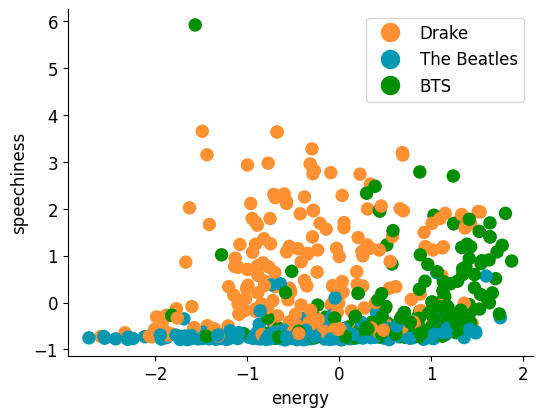

In [6]:
from matplotlib.lines import Line2D

# chose the axes for each feature
x_var = 3
y_var = 6

fig, axs = plt.subplots(1,1,figsize=(FIG_WIDTH*1.5,FIG_HEIGHT*1.5))
# we can now use the colormap we defined
axs.scatter(data[:,x_var],data[:,y_var],c=cmap,s=75)
legend_elements = [Line2D([0],[0],marker='o',color='w',label=artists[i],
                          markerfacecolor=colors[i], markersize=15) for i in range (len(artists))]
axs.legend(handles=legend_elements)
axs.set_xlabel(features[x_var])
axs.set_ylabel(features[y_var])
plt.show()

Okay so from the image we can see that Drake clearly has less energy than the famous Korean Boy Band, and he does have a lot more to say than The Beatles. From here we can already see the clusters, but how will K-Means do when using all 11 dimensions?

#### II. K-Means Clustering

Given a dataset $\mathcal{X}=\{x_1,x_2,\ldots,x_N\}$ of $d$-dimensional vectors $x$, we want to find $k$ centroids, $\mathcal{C}=\{c_1,c_2,\ldots,c_k\}$, that minimze the distorion,$\mathcal{D}$ of our data. Where:

$$\mathcal{D}=\sum_{i=1}^{N}||x_i-c_{x_i}||_2$$

Above I denote $c_{x_i}$ as the centroid corresponding to data sample $x_i$.

I will skip the mathematical notation as the algorithm is quite simply stated in words. There are essentially three steps.

1) Initialize the Centroids Randomly


REPEAT (2-3):

2) For each point, find which centroid it is closest to and make it part of its cluster. 

3) Find the new cluster centers by taking the mean of the sets associated with each cluster. 

A good measure for convergence in K-Means is distrotrion, which is the total variance across all clusters. K-Means tries to minimize the distortion, which is the sum of squared distances from the data-points and their corresponding centers. It would be wise to somehow use this measure in your algorithm.

### Question 1: Implementing K-Means

Using the data processed above, implement the K-Means algorithm. Feel free to do this in any way you like, there is only one requirement that I need for evaluation: utilize the `K_Means` function provided below, keeping the I/O the same. This will allow you to use the evaluation cell that follows. 

**Note**: the function does not return the dataset, only the centroids (and distortion). This is important, as the order of the labels corresponds to the original order of the dataset, and hence both should remain unchanged. 

In [7]:
def K_Means(X, K):
    '''
    Your K-Means iplementatio goes here. Feel free to use more cells to define additional functions

    Inputs:
        X - Data as np.array of dim: N x d
        K - Number of centroids
    
    Outputs
        m - np.array of FINAL cluster centers, dim: K x d
        D - The final distortion
    '''
    epoch = 0
    print("Initializing...")
    print('K: %d, N: %d' %(K, X.shape[0]))
    print('----'*8)
    try:
        dim = X.shape[1]
    except:
        dim = 1
    
    # you can delete these two lines
    m = np.zeros((K, dim))
    Distortion = 0
    
    
    return m, Distortion

Run your algorithm in the cell below and store the centroids for the next part.

In [8]:
m, D = K_Means(data, len(artists))

Initializing...
K: 3, N: 600
--------------------------------


Let us evaluate. 

For the cell to work, you will need to have the variable `m` in the format I asked for.

In [9]:
artist_count = np.zeros((len(artists),len(artists)))
for idx in range(data.shape[0]):
    distance = np.linalg.norm((data[idx]-m),axis=1)**2
    centroid = np.argmin(distance)
    artist = labels[idx]
    artist_count[centroid][np.argwhere(artist == artists).item()] += 1

print('\t',end="")
for art in artists:
    print(art[0:6]+'\t',end="")
print('\n')
for i in range(artist_count.shape[0]):
    print('K = %d \t'%i,end="")
    for j in range(artist_count.shape[1]):
        print(str(int(artist_count[i,j]))+'\t',end="")
    print("\n")
    



	Drake	The Be	BTS	

K = 0 	200	200	200	

K = 1 	0	0	0	

K = 2 	0	0	0	



Above you should see a table that records on each row i, how many songs from each artist (columns) went to centroid i. You should see the majority of one artist's songs going to a distinct cluster. If that is the case for all the artists, then K-Means worked pretty well. Note that there are other ways to evaluate the performance of K-Means now that we have our labels, but we will skip this discussion. 

#### III. Binary Gaussian Mixtures 

A Binary Gaussian Mixture model defines a random variable $X$ whose probability density function (pdf) $P(X=x)$ is expressed as a sum of two weighted Gaussian distributions $g_0(x),g_1(x)$:

$$
p(X=x) = (1-\pi)g_0(x) + \pi g_1(x),
$$

where $g_0(x)$ and $g_1(x)$ are the pdfs of the distributions $\mathcal{N(\mu_0,\sigma_0^2)}$ and $\mathcal{N(\mu_1,\sigma_1^2)}$ respecitevely. These pdfs are sometimes denoted to as $\phi_{\mu_0,\sigma_0^2}$, and $\phi_{\mu_1,\sigma_1^2}$, and they can be computed by using the exact equation of the pdf. For our this lab, we will rely on [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html for sampling and evaluating these distributions. 

Below we generate and visualize the mixture model corresponding to these parameters:

$$
\begin{aligned}
u_1 &= 1.3, \\
u_2 &= -1.8, \\
\sigma_1 &= 0.7, \\
\sigma_2 &= 1.5, \\
\pi &= 0.3.
\end{aligned}
$$

In [10]:
def plot_gmm(X,pi,mu,sigma,sol=None):
    '''
    Plots a GMM that is 1-dimensional and has 2-components.
    Uses scipy.stas to overlay the predicted gaussians

    Inputs: 
        X     - input data as 1-d np.array
        pi    - prior of componenet 1 (not 0)
        mu    - np array of means 
        sigma - np.array of stds
    '''
    # range of values
    MIN, MAX = X.min(), X.max()
    domain = np.linspace(MIN, MAX,100)

    fig, axs = plt.subplots(1,1)
    axs.set_xlim(MIN, MAX)
    # plot our values as a distribution
    axs.hist(X,bins=100,density=True,color='gray',alpha=0.3)
    # now plot the predicted gaussians over the same range
    g0 = (1-pi)*norm.pdf(domain,mu[0],scale=sigma[0])
    g1 = (pi)*norm.pdf(domain,loc=mu[1],scale=sigma[1])

    axs.plot(domain,g0,color=ORANGE,label='$g_0$',linestyle='--')
    axs.plot(domain,g1,color=TEAL,label='$g_1$',linestyle='--')
    plt.vlines(x=mu[0],ymin=0,ymax=g0[int(100*abs(MIN-mu[0])/abs(MAX-MIN))],color=ORANGE,label='$\mu_0$',alpha=0.5,linewidth=5)
    plt.vlines(x=mu[1],ymin=0,ymax=g1[int(100*abs(MIN-mu[1])/abs(MAX-MIN))],color=TEAL,label='$\mu_1$',alpha=0.5,linewidth=5)

    if sol is not None:
        plt.vlines(x=sol[0],ymin=0,ymax=g0[int(100*abs(MIN-sol[0])/abs(MAX-MIN))],color=ORANGE,label='$\hat{\mu}_0$',linewidth=2)
        plt.vlines(x=sol[1],ymin=0,ymax=g1[int(100*abs(MIN-sol[1])/abs(MAX-MIN))],color=TEAL,label='$\hat{\mu}_1$',linewidth=2)

    axs.legend()
    plt.xlabel('$x$')
    plt.ylabel('$P(x)$')
    plt.title('Gaussian Mixture Model')

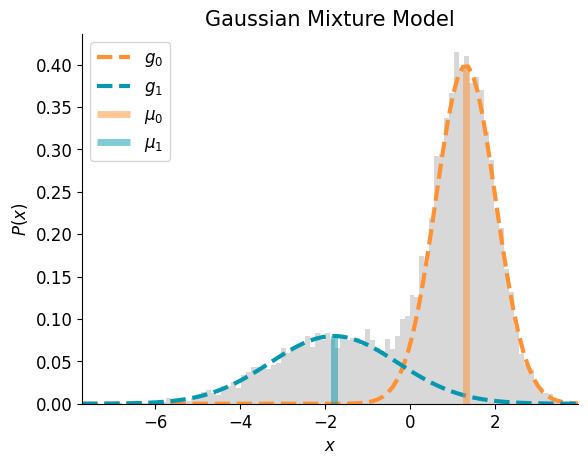

In [11]:
# these are the parameters
data = {'mu': [1.3, -1.8],
        'sigma': [0.7, 1.5],
        'pi': 0.3,}

# we will generate N samples
N = 10000 
# Generate random uniform values to decide which component each sample comes from
z = np.random.rand(N) 
# Create an array to hold all samples
samples = np.empty(N)
# Mask that selects which component to sample
g_1_mask = (z < data['pi'])
g_0_mask = ~g_1_mask
# Sample from the first Gaussian (mu=1.3, sigma=0.7)
samples[g_0_mask] = norm(loc=data['mu'][0],
                        scale=data['sigma'][0]
                        ).rvs(size=g_0_mask.sum())
# Sample from the second Gaussian (mu=-1.8, sigma=1.5)
samples[g_1_mask] = norm(loc=data['mu'][1],
                        scale=data['sigma'][1]
                        ).rvs(size=g_1_mask.sum())
# save and plot
data['X'] = samples
plot_gmm(data['X'],data['pi'],data['mu'],data['sigma'])

The above cell generated the data, where `data['X']` is your unlabeled dataset, and this time you are not given the labels since all the information about the data comes from the parameters. What are the parameters? The prior, the standard deviations, and the means. Your job is to use the EM algorithm to find these values. You can use the true values (of the parameters) to test how well your algorithm is doing.

Take note of how I used:

```python
g0 = (1-pi)*norm.pdf(domain,mu[0],scale=sigma[0])
g1 = (pi)*norm.pdf(domain,loc=mu[1],scale=sigma[1])
```

to get the values of the pdf for all locations that I wanted. You will need to use this function in your code for EM.

Before continuing, lets check how the uninformed K-Means algorithm would perform here. Note the extra variable `sol` in the plotting function allows you to check your solution for the mean, where we ignore the std and prior for now. 

Initializing...
K: 2, N: 10000
--------------------------------


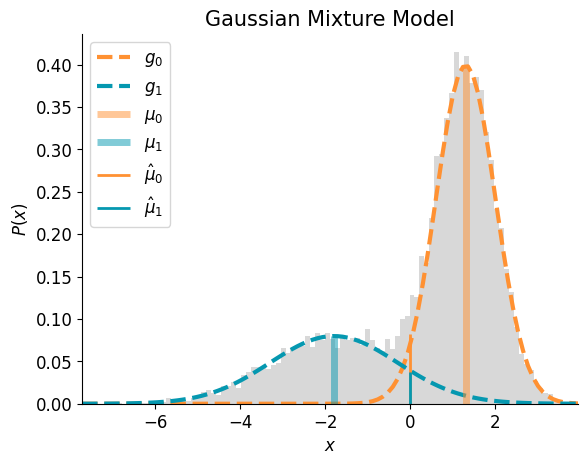

In [12]:
mu, D = K_Means(data['X'],2)
mu = mu.squeeze() # packs the data into one dimension
plot_gmm(data['X'],data['pi'],data['mu'],data['sigma'],sol=mu)

Not bad, but also quite skewed. K-Means does not account for clusters having different variances, and hence it skews the distribution means to the left when minimizing the distortion. Since the data is actually represented by a Gaussian mixture model, we should be able to get a more accurate result using the EM algorithm.

### IV. EM Algorithm

You are given a dataset $\mathcal{X}=\{x_1,x_2,\ldots,x_N\}$ of one-dimensinoal samples $x$ that come from a binary Guassian mixture model with the following true parameters:

$$\mu_0, \mu_1, \sigma_0, \sigma_1, \pi$$

We want to estimate these parameters, and hence we preform the EM algorithm  by doing the following steps:

1) Take initial guesses for the parameters (use K-Means): 
$$
\hat{\mu_0}, \hat{\mu_1}, \hat{\sigma_0}, \hat{\sigma_1}, \hat{\pi}
$$

2) **Expectation**-step:

compute the responsabilities, $\gamma_i$ for each sample $x_i$. These values estimate the probability that given the current parameters, **$x_i$ belongs to component 1**:

$$
\gamma_i = \frac{\hat{\pi}\phi_{\hat{\mu_1},\hat{\sigma_1}^2}(x_i)}{(1-\hat{\pi})\phi_{\hat{\mu_0},\hat{\sigma_0}^2}(x_i)+\hat{\pi}\phi_{\hat{\mu_1},\hat{\sigma_1}^2}(x_i)},\quad i=1,2,\ldots,N
$$

3) **Maximization**-step: 

compute the weighted means and variances using these responsabilities.

$$
\hat{\mu_0}=\frac{\sum_{i=1}^{N}\big((1-\gamma_i)x_i\big)}{\sum_{i=1}^{N}(1-\gamma_i)}, \quad \hat{\mu_1}=\frac{\sum_{i=1}^{N}\big(\gamma_i x_i\big)}{\sum_{i=1}^{N}\gamma_i}
$$

$$
\hat{\sigma_0^2}=\frac{\sum_{i=1}^{N}\big((1-\gamma_i)(x_i-\hat{\mu_0})^2\big)}{\sum_{i=1}^{N}(1-\gamma_i)}, \quad \hat{\sigma_1^2}=\frac{\sum_{i=1}^{N}\big(\gamma_i (x_i-\hat{\mu_1})^2\big)}{\sum_{i=1}^{N}\gamma_i}
$$

and rescale the prior

$$
\hat{\pi} = \frac{1}{N}\sum_{i=1}^{N}\gamma_i
$$
Reapeat the Expectation and Maximization Steps until convergence.

**Note**: you are updating the variance, not the standard deviation. 

### Question 2: Implementing EM

As in the previous question, you are responsible for implementing EM on your own. The only requirements are the I/O of the `EM` function defined below. 

In [13]:
def EM(X):
    '''
    The EM algorithm in it's least-full form. 

    Inputs:
        X - np.array of length N, since this is one dimensional data
    
    Outputs:
        pi    - just a floating point representing your FINAL prior
        mu    - 2-dimensional np.array, with your FINAL mu_0 and mu_1
        sigma - 2-dimensional np.array, with your FINAL sigma_0 and sigma_1
    '''
    # take initial guess
    mu, _ = K_Means(data['X'],2)
    mu = mu.squeeze()
    pi = 0.5
    sigma = rng.random(2)*2
    # Iterate until covnergence
    print('----'*8)
    print("Running EM")


    return pi,mu,sigma

Run your EM algorithm, and evaluate it below. I provide you with a table that compares how close the predicted values are to the ground truth. Make sure to use the output format so that this works. You should notice that the predicted values are close to the ground truth, and the overall result is an improvement over K-Means.

Initializing...
K: 2, N: 10000
--------------------------------
--------------------------------
Running EM
		 True Values 	 Predicted 	 Error
pi 		 0.30 		 0.50 		 0.20 
mu_0 		 1.30 		 0.00 		 1.30
mu_1 		 -1.80 		 0.00 		 1.80
sigma_0 	 0.70 		 0.45 		 0.25
sigma_1 	 1.50 		 0.63 		 0.87



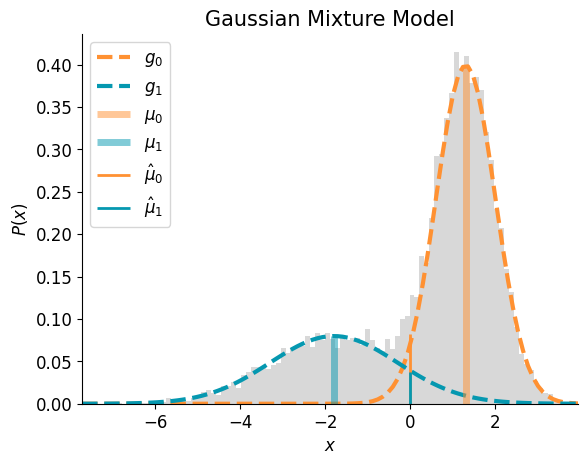

In [14]:
n_pi, n_mu, n_sigma= EM(data['X'])
# results
print('\t\t True Values \t Predicted \t Error')
print('pi \t\t %.2f \t\t %.2f \t\t %.2f '%(data['pi'],n_pi,abs(n_pi-data['pi'])))
print('mu_0 \t\t %.2f \t\t %.2f \t\t %.2f'%(data['mu'][0],n_mu[0],abs(n_mu[0]-data['mu'][0])))
print('mu_1 \t\t %.2f \t\t %.2f \t\t %.2f'%(data['mu'][1],n_mu[1],abs(n_mu[1]-data['mu'][1])))
print('sigma_0 \t %.2f \t\t %.2f \t\t %.2f'%(data['sigma'][0],n_sigma[0],abs(n_sigma[0]-data['sigma'][0])))
print('sigma_1 \t %.2f \t\t %.2f \t\t %.2f\n'%(data['sigma'][1],n_sigma[1],abs(n_sigma[1]-data['sigma'][1])))

plot_gmm(data['X'],data['pi'],data['mu'],data['sigma'],sol=n_mu)
